# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this [link](https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312). Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following [link](https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ). 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

# Linear Model for csv_v1

In [ ]:
# importing the required libraries libraries
import warnings, requests, zipfile, io

warnings.simplefilter("ignore")
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Function: initialize_s3_container

This function initializes an S3 bucket in a specified AWS region, creating a new storage container if it does not already exist. The function includes logic to handle both default and custom AWS regions.

In [ ]:
import logging

# import boto3
from botocore.exceptions import ClientError

def initialize_s3_container(storage_name, locality=None):
    """
    Initialize an S3 storage bucket in a specified AWS region.
    If no region is specified, the bucket will default to 'us-east-1'.
    
    :param storage_name: Name of the bucket to create
    :param locality: AWS region for bucket creation, e.g., 'us-west-2'
    :return: True if bucket creation succeeds, otherwise False
    """

    try:
        if locality is None:
            s3_service = boto3.client("s3")
            s3_service.create_bucket(Bucket=storage_name)
        else:
            s3_service = boto3.client("s3", region_name=locality)
            config_location = {"LocationConstraint": locality}
            s3_service.create_bucket(
                Bucket=storage_name, CreateBucketConfiguration=config_location
            )

    except ClientError as error_log:
        logging.error(error_log)
        return False

    print(f"S3 Bucket: {storage_name} has been successfully created.")
    return True


# Function: verify_bucket_presence

This function checks whether an S3 bucket with a specified name exists in the AWS account. It’s helpful for ensuring that a required bucket is available before performing further operations, such as uploading data.

In [ ]:
# Function to verify if the bucket exists
def verify_bucket_presence(storage_identifier):
    s3_resource = boto3.client("s3")
    try:
        s3_resource.head_bucket(Bucket=storage_identifier)
        print(f"Bucket '{storage_identifier}' is already available.")
        return True
    except ClientError as error_detected:
        # If a 404 error is encountered, the bucket does not exist
        if error_detected.response["Error"]["Code"] == "404":
            print(f"Bucket '{storage_identifier}' is not found.")
            return False
        else:
            # Raise any other error encountered
            raise


# S3 Bucket Setup and Validation

In this section, we set up the S3 bucket and check if it already exists. If the bucket does not exist, we create it to ensure that all necessary storage resources are available for our project.

In [ ]:
# Set the S3 bucket name with valid characters
s3_container_name = "u3265713-uni-can-dsts-assn1"

# Fetch the S3 resource
s3_instance = boto3.Session().resource("s3")

# Check if the bucket exists
container_exists = verify_bucket_presence(s3_container_name)

# Create the bucket if it doesn't exist
if not container_exists:
    initialize_s3_container(s3_container_name)



Bucket 'u3265713-uni-can-dsts-assn1' is not found.
S3 Bucket: u3265713-uni-can-dsts-assn1 has been successfully created.


# Setting S3 Path Prefix and Uploading CSV Data to S3

In this section, we define a prefix for the S3 path and create a function to upload a DataFrame as a CSV file to an S3 bucket. This setup is essential for organizing and storing data in a structured manner within AWS S3.

In [ ]:
# Setting the prefix for the S3 path
s3_prefix = "oncloud"

# Function to upload CSV data to AWS S3
def upload_csv_to_s3(file_name, subfolder, data_frame):
    csv_memory_buffer = io.StringIO()
    data_frame.to_csv(csv_memory_buffer, header=False, index=False)
    print(s3_instance.Bucket(s3_container_name))
    s3_instance.Bucket(s3_container_name).Object(os.path.join(s3_prefix, subfolder, file_name)).put(
        Body=csv_memory_buffer.getvalue()
    )


# Loading the Dataset

In [ ]:
# Load the data
dataset_v1 = pd.read_csv("./combined_csv_v1.csv")

print(dataset_v1.head())
print(dataset_v1.shape)


   target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
0     0.0     689.0      False      False      False    False    False   
1     0.0     731.0      False      False      False    False    False   
2     0.0    1199.0      False      False      False    False    False   
3     0.0    1587.0      False      False      False    False    False   
4     0.0    1587.0      False      False      False    False    False   

   Month_4  Month_5  Month_6  ...  Dest_DEN  Dest_DFW  Dest_IAH  Dest_LAX  \
0    False    False    False  ...     False     False      True     False   
1    False    False    False  ...     False     False     False     False   
2    False    False    False  ...      True     False     False     False   
3    False    False    False  ...     False     False     False     False   
4    False    False    False  ...     False     False     False     False   

   Dest_ORD  Dest_PHX  Dest_SFO  DepHourofDay_7-12  DepHourofDay_13-18  \
0     False     Fa

# Creating a Copy of the Dataset

In [ ]:
# Copying the data 
df = dataset_v1.copy()

# Data Transformation: Converting Boolean Values

In [ ]:
# Replacing True/False with 1/0 directly in df
df = df.replace({True: 1, False: 0})
df.head(5)


,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_7-12,DepHourofDay_13-18,DepHourofDay_19-23
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Splitting the dataset

In [ ]:
# Split the data into training and a combined testing/validation set (70% train, 30% test/validate)
training_data, testing_validation_data = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["target"]
)

# Further split the testing_validation_data set into separate testing and validation sets (15% each of the original data)
testing_data, validation_data = train_test_split(
    testing_validation_data,
    test_size=0.5,
    random_state=42,
    stratify=testing_validation_data["target"],
)


In [ ]:
# Printing the shapes of each set 
print(training_data.shape)
print(testing_data.shape)
print(validation_data.shape)


(1144913, 75)
(245338, 75)
(245339, 75)


# Defining File Names for Data Subsets

In [ ]:
# Set the names of the CSV files for each data subset
# These file names will be used to save the training, testing, and validation datasets 
# as CSV files, allowing for easy upload to S3 and subsequent use in modeling.
training_file_name = "data_v1_train.csv"      # Filename for the training dataset
testing_file_name = "data_v1_test.csv"        # Filename for the testing dataset
validation_file_name = "data_v1_validate.csv" # Filename for the validation dataset


# Preparing Data for SageMaker Training

The transform_data_for_sagemaker function converts a DataFrame into a SageMaker-compatible format. It separates feature vectors and target labels, storing them in an in-memory binary buffer. This format is optimized for SageMaker’s training processes.

In [ ]:
import io
import numpy as np
import sagemaker.amazon.common as smac

# Function to prepare data for SageMaker training
# This function converts a dataframe into a format suitable for SageMaker training,
# separating features (input data) and labels (target values) and storing them in 
# an in-memory binary buffer that SageMaker can efficiently use.
def transform_data_for_sagemaker(input_df):
    # Extract feature vectors by dropping the target column and converting to float32
    feature_vectors = input_df.drop(columns=["target"]).values.astype("float32")
    # Extract target labels from the target column and convert to float32
    target_labels = input_df["target"].values.astype("float32")
    # Initialize an in-memory binary stream buffer to hold the transformed data
    memory_buffer = io.BytesIO()
    # Use SageMaker's utility function to write data in dense tensor format into the buffer
    smac.write_numpy_to_dense_tensor(memory_buffer, feature_vectors, target_labels)
    # Reset buffer position to the start to allow SageMaker to read from the beginning
    memory_buffer.seek(0)
    # Return the in-memory buffer ready for SageMaker ingestion
    return memory_buffer


In [ ]:
# Function to upload a data buffer to S3
# This function takes an in-memory buffer, S3 bucket, prefix, and data type (e.g., train, test),
# and uploads the data in 'recordIO' format to a specified location in the S3 bucket.

def upload_buffer_to_s3(data_buffer, s3_bucket, s3_prefix, data_type):
    # Set a fixed S3 key (filename) for the data
    s3_key_name = "recordio-pb-data"
    
    # Perform the upload to the specified S3 bucket and path
    boto3.resource("s3").Bucket(s3_bucket).Object(
        os.path.join(s3_prefix, data_type, s3_key_name)
    ).upload_fileobj(data_buffer)
    
    # Construct and print the S3 path where the data has been uploaded
    s3_data_path = "s3://{}/{}/{}/{}".format(s3_bucket, s3_prefix, data_type, s3_key_name)
    print("Uploaded {} data to location: {}".format(data_type, s3_data_path))
    
    # Return the S3 path for reference
    return s3_data_path

# Uploading Data Buffer to S3

In [ ]:
# Prepare training data buffer for SageMaker
# Converts the training dataset into a format suitable for SageMaker and stores it in an in-memory buffer
training_data_buffer = transform_data_for_sagemaker(training_data)
# Upload the training data buffer to S3
# This uploads the training buffer to the specified S3 bucket under the prefix path for "train" data
s3_training_data_path = upload_buffer_to_s3(training_data_buffer, s3_container_name, s3_prefix, "train")
# Prepare validation data buffer for SageMaker
# Converts the validation dataset into a SageMaker-compatible format and stores it in an in-memory buffer
validation_data_buffer = transform_data_for_sagemaker(validation_data)
# Upload the validation data buffer to S3
# This uploads the validation buffer to the specified S3 bucket under the prefix path for "validate" data
s3_validation_data_path = upload_buffer_to_s3(validation_data_buffer, s3_container_name, s3_prefix, "validate")


Uploaded train data to location: s3://u3265713-uni-can-dsts-assn1/oncloud/train/recordio-pb-data
Uploaded validate data to location: s3://u3265713-uni-can-dsts-assn1/oncloud/validate/recordio-pb-data


# Setting the S3 Output Location for Training Artifacts

In [ ]:
# Define the S3 output location for training artifacts
# This path specifies where SageMaker should store the output artifacts after training is complete.
# The output location is set under the specified S3 bucket and prefix, organized in an "output" folder.
output_artifact_location = "s3://{}/{}/output".format(s3_container_name, s3_prefix)
# Print the S3 path where training artifacts will be uploaded
print("Training artifacts will be uploaded to: {}".format(output_artifact_location))


Training artifacts will be uploaded to: s3://u3265713-uni-can-dsts-assn1/oncloud/output


# Retrieving the SageMaker Container Image URI

In [ ]:
from sagemaker.image_uris import retrieve
# Retrieve the container image URI for the SageMaker algorithm
# This retrieves the URI for the specified algorithm container (linear-learner) in the given AWS region.
# The container image is needed to launch the training job on SageMaker using the specified algorithm.
model_container_uri = retrieve("linear-learner", "us-east-1")


# Setting Up and Running the SageMaker Training Job

In [ ]:
# Create a SageMaker session
# This session is initialized with the specified region (us-east-1) to match the region of the S3 bucket.
# It will manage the communication with AWS services for the training job.
sagemaker_session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))
# Retrieve the IAM role for SageMaker
# The role grants SageMaker permissions to access AWS resources such as S3.
execution_role = sagemaker.get_execution_role()
# Set up the SageMaker Estimator for training a linear model
# This estimator is configured with the model container URI, IAM role, instance count, instance type,
# output path for training artifacts, and the SageMaker session.
linear_estimator = sagemaker.estimator.Estimator(
    model_container_uri,            # Container URI for the chosen algorithm (linear-learner)
    execution_role,                 # IAM role for SageMaker permissions
    train_instance_count=1,         # Number of instances for training (1 in this case)
    train_instance_type="ml.c5.4xlarge",  # Instance type for training
    output_path=output_artifact_location, # S3 location for output artifacts
    sagemaker_session=sagemaker_session  # Session for AWS resource management
)
# Set hyperparameters for the linear model
# Here, we specify the feature dimension and the type of predictor (binary classifier).
linear_estimator.set_hyperparameters(feature_dim=74, predictor_type="binary_classifier")
# Start the training job on SageMaker
# The training data and validation data are passed as input channels to the estimator.
# Setting logs=False suppresses detailed logging during training.
linear_estimator.fit({"train": s3_training_data_path, "validation": s3_validation_data_path}, logs=False)


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



2024-11-03 06:01:39 Starting - Starting the training job..
2024-11-03 06:01:53 Starting - Preparing the instances for training.....
2024-11-03 06:02:25 Downloading - Downloading input data....
2024-11-03 06:02:50 Downloading - Downloading the training image........
2024-11-03 06:03:35 Training - Training image download completed. Training in progress.........................................................................
2024-11-03 06:09:42 Uploading - Uploading generated training model
2024-11-03 06:09:50 Completed - Training job completed


# Preparing and Uploading Data for Batch Prediction

In [ ]:
# Prepare the input data for batch prediction
# This selects all columns except the target from the test data for predictions.
# The data will be saved in a CSV format for batch processing on SageMaker.
batch_input_data_df = testing_data.iloc[:, 1:]         # Exclude target column for batch prediction
batch_input_file_name = 'batch-input-linear.csv'       # Name for the batch input CSV file

# Upload the batch input data CSV to S3
# This function uploads the batch prediction input file to a specific S3 location.
upload_csv_to_s3(batch_input_file_name, 'batch-input-folder', batch_input_data_df)

# Define S3 paths for batch input and output
# The batch_output_path specifies where SageMaker should store the prediction results.
# The batch_input_path points to the location of the uploaded CSV file in S3.
batch_output_path = "s3://{}/{}/batch-output-linear/".format(s3_container_name, s3_prefix)
batch_input_path = "s3://{}/{}/batch-input-folder/{}".format(s3_container_name, s3_prefix, batch_input_file_name)


s3.Bucket(name='u3265713-uni-can-dsts-assn1')


# Setting Up and Running the Batch Transform Job

In [ ]:
# Create the transformer object for the Linear Learner model
# The transformer handles batch predictions by using the trained model and specified S3 locations for input and output.
# We configure the instance count and type for the transform job, as well as data handling strategies.
linear_model_transformer = linear_estimator.transformer(
    instance_count=1,                       # Number of instances to use for batch transform
    instance_type='ml.c5.4xlarge',          # Instance type for the transform job
    strategy='MultiRecord',                 # Strategy for combining multiple records into a single batch request
    assemble_with='Line',                   # Assembling records by line, suitable for CSV format
    output_path=batch_output_path           # S3 path to store the batch prediction results
)

# Start the batch transform job
# This initiates the transform job using the transformer, specifying the input data and content type.
linear_model_transformer.transform(
    data=batch_input_path,                  # S3 path of input data for batch predictions
    data_type='S3Prefix',                   # Type of data in S3 (prefix for files in this case)
    content_type='text/csv',                # Content type of input data
    split_type='Line',                      # Split records by line (each line represents one data instance)
    logs=False                              # Suppress logging during the batch transform job
)

# Wait for the batch transform job to complete
linear_model_transformer.wait()


.......................................................................................!
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 06:20:33 INFO 140106871093056] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 06:20:33 INFO 140106871093056] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/op

# Retrieving and Reading Batch Prediction Results from S3

In [ ]:
# Fetch and read the batch prediction output from S3
# This code retrieves the batch transform output file from S3 and reads it into a DataFrame for further analysis.
s3_client = boto3.client('s3')
# Define the S3 key for the batch output file
# This path points to the output folder and file created by the batch transform job.
batch_output_key = "{}/batch-output-linear/{}".format(s3_prefix, 'batch-input-linear.csv.out')
# Fetch the output object from S3
# Retrieves the batch prediction results from the specified S3 bucket and key.
output_object = s3_client.get_object(Bucket=s3_container_name, Key=batch_output_key)
# Read the prediction results into a DataFrame
# Loads the output data from the batch transform job into a DataFrame.
# The DataFrame is assigned column name 'class' to represent the predicted classes.
predicted_target_df = pd.read_csv(io.BytesIO(output_object['Body'].read()), header=None, names=['class'])
# Print or further process the predictions
# Display the first few rows of predictions to verify results or for further analysis.
predicted_target_df.head(5)


,class
"{""predicted_label"":0",score:0.20226565003395}
"{""predicted_label"":0",score:0.20329600572586}
"{""predicted_label"":0",score:0.188853055238723}
"{""predicted_label"":0",score:0.200587853789329}
"{""predicted_label"":0",score:0.203493922948837}


# Extracting and Processing Prediction Results

In [ ]:
# Extract the prediction indices from the DataFrame
# This extracts the indices of each prediction result for further processing.
predicted_indices = predicted_target_df.index

# Example of accessing the last character of the first prediction index
# Retrieves the last character from the first index, which might represent a label or identifier.
predicted_indices[0][-1]

# Extract the middle portion of the first prediction result
# Slices the first prediction string to exclude specific characters (used here as an example).
predicted_target_df.iloc[0, 0][6:-1]

# Define a list of prediction labels based on the indices
# Extracts the last character of each index, assuming it represents the prediction label.
predicted_labels = [str(pred_index)[-1] for pred_index in predicted_indices]

# Define a list of prediction scores based on the DataFrame rows
# Extracts the prediction score for each row, excluding specific characters.
predicted_scores = [str(row[0])[6:-1] for row in predicted_target_df.itertuples(index=False)]

# Convert prediction scores and labels to numeric types
# Ensures the extracted scores and labels are in numeric form for further analysis.
predicted_scores = pd.to_numeric(predicted_scores)
predicted_labels = pd.to_numeric(predicted_labels)


# Plotting the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Function to plot a confusion matrix
# This function generates a heatmap to visualize the confusion matrix,
# which helps assess the accuracy of classification by comparing actual and predicted labels.
def display_confusion_matrix(actual_labels, predicted_labels):
    # Generate the confusion matrix
    # The matrix compares actual labels with predicted labels to show true positives, false positives, etc.
    confusion_mat = confusion_matrix(actual_labels, predicted_labels)
    # Create a heatmap for the confusion matrix
    # This provides a visual representation of the matrix for easy interpretation.
    sns.heatmap(
        confusion_mat,
        annot=True,               # Display numerical values within each cell
        fmt="d",                  # Format as integer values
        cmap="Blues",             # Color scheme for the heatmap
        xticklabels=["On-Time", "Delayed"],  # Labels for the x-axis (predicted outcomes)
        yticklabels=["On-Time", "Delayed"],  # Labels for the y-axis (actual outcomes)
    )
    # Label the plot axes and title
    plt.xlabel("Predicted Labels")  # Label for the x-axis
    plt.ylabel("Actual Labels")     # Label for the y-axis
    plt.title("Confusion Matrix")   # Title of the plot
    plt.show()                      # Display the plot

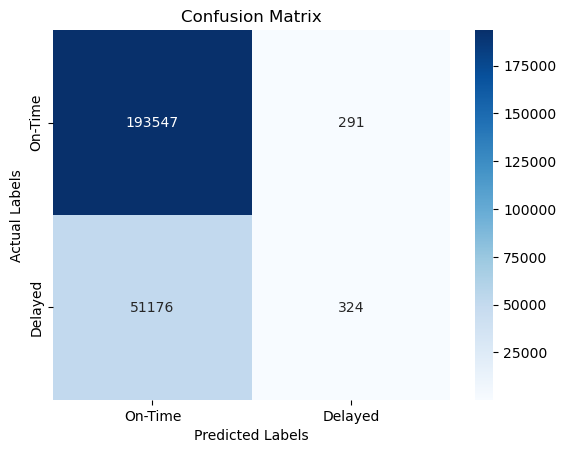

In [ ]:
# Display confusion matrix for the test data
# This compares the actual test labels with the predicted labels and visualizes the classification performance.
# `test.iloc[:, 0]` extracts the actual labels from the test dataset.
display_confusion_matrix(
    actual_labels=testing_data.iloc[:, 0],  # Actual labels from the first column of test data
    predicted_labels=predicted_labels       # Predicted labels obtained from the model
)


# Generating the Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Generate and display the classification report for the test data
# This report provides detailed metrics such as precision, recall, and F1-score
# for each class, helping assess the performance of the model.
print("Classification Report on Test Data")
print(classification_report(
    testing_data.iloc[:, 0],    # Actual labels from the first column of test data
    predicted_labels             # Predicted labels generated by the model
))


Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    193838
         1.0       0.53      0.01      0.01     51500

    accuracy                           0.79    245338
   macro avg       0.66      0.50      0.45    245338
weighted avg       0.74      0.79      0.70    245338



# Linear Model for csv_v2

# Loading the Dataset

In [ ]:
# Load the data
dataset_v2 = pd.read_csv("./combined_csv_v2.csv")

print(dataset_v2.head())
print(dataset_v2.shape)


   target  Distance  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  TAVG_D  SNOW_O  \
0     0.0     689.0      33       0    54.0      30       0   130.0     0.0   
1     0.0     731.0      39       0   136.0      33       0    54.0     0.0   
2     0.0    1199.0      33       0    54.0      77       0    68.0     0.0   
3     0.0    1587.0      33       0    54.0      20       0   165.0     0.0   
4     0.0    1587.0      20       0   165.0      33       0    54.0     0.0   

   SNOW_D  ...  Dest_DFW  Dest_IAH  Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  \
0     0.0  ...     False      True     False     False     False     False   
1     0.0  ...     False     False     False     False     False     False   
2     0.0  ...     False     False     False     False     False     False   
3     0.0  ...     False     False     False     False      True     False   
4     0.0  ...     False     False     False     False     False     False   

   is_holiday_True  DepHourofDay_7-12  DepHourofDay_13-1

# Creating a Copy of the Dataset

In [ ]:
# Copying the data 
df = dataset_v2.copy()

# Data Transformation: Converting Boolean Values


In [ ]:
# Replacing True/False with 1/0 directly in df
df = df.replace({True: 1, False: 0})
df.head(5)


,target,Distance,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,SNOW_D,...,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_True,DepHourofDay_7-12,DepHourofDay_13-18,DepHourofDay_19-23
0,0.0,689.0,33,0,54.0,30,0,130.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
1,0.0,731.0,39,0,136.0,33,0,54.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,33,0,54.0,77,0,68.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,33,0,54.0,20,0,165.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
4,0.0,1587.0,20,0,165.0,33,0,54.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


# Splitting the dataset

In [ ]:
# Split the data into training and a combined testing/validation set (70% train, 30% test/validate)
training_data, testing_validation_data = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["target"]
)

# Further split the testing_validation_data set into separate testing and validation sets (15% each of the original data)
testing_data, validation_data = train_test_split(
    testing_validation_data,
    test_size=0.5,
    random_state=42,
    stratify=testing_validation_data["target"],
)


In [ ]:
# Printing the shapes of each set 
print(training_data.shape)
print(testing_data.shape)
print(validation_data.shape)


(1144913, 88)
(245338, 88)
(245339, 88)


# Defining File Names for Data Subsets

In [ ]:
# Set the names of the CSV files for each data subset
# These file names will be used to save the training, testing, and validation datasets 
# as CSV files, allowing for easy upload to S3 and subsequent use in modeling.
training_file_name = "data_v1_train.csv"      # Filename for the training dataset
testing_file_name = "data_v1_test.csv"        # Filename for the testing dataset
validation_file_name = "data_v1_validate.csv" # Filename for the validation dataset


# Preparing Data for SageMaker Training

The transform_data_for_sagemaker function converts a DataFrame into a SageMaker-compatible format. It separates feature vectors and target labels, storing them in an in-memory binary buffer. This format is optimized for SageMaker’s training processes.

In [ ]:
import io
import numpy as np
import sagemaker.amazon.common as smac

# Function to prepare data for SageMaker training
# This function converts a dataframe into a format suitable for SageMaker training,
# separating features (input data) and labels (target values) and storing them in 
# an in-memory binary buffer that SageMaker can efficiently use.
def transform_data_for_sagemaker(input_df):
    # Extract feature vectors by dropping the target column and converting to float32
    feature_vectors = input_df.drop(columns=["target"]).values.astype("float32")
    # Extract target labels from the target column and convert to float32
    target_labels = input_df["target"].values.astype("float32")
    # Initialize an in-memory binary stream buffer to hold the transformed data
    memory_buffer = io.BytesIO()
    # Use SageMaker's utility function to write data in dense tensor format into the buffer
    smac.write_numpy_to_dense_tensor(memory_buffer, feature_vectors, target_labels)
    # Reset buffer position to the start to allow SageMaker to read from the beginning
    memory_buffer.seek(0)
    # Return the in-memory buffer ready for SageMaker ingestion
    return memory_buffer


In [ ]:
# Function to upload a data buffer to S3
# This function takes an in-memory buffer, S3 bucket, prefix, and data type (e.g., train, test),
# and uploads the data in 'recordIO' format to a specified location in the S3 bucket.

def upload_buffer_to_s3(data_buffer, s3_bucket, s3_prefix, data_type):
    # Set a fixed S3 key (filename) for the data
    s3_key_name = "recordio-pb-data"
    
    # Perform the upload to the specified S3 bucket and path
    boto3.resource("s3").Bucket(s3_bucket).Object(
        os.path.join(s3_prefix, data_type, s3_key_name)
    ).upload_fileobj(data_buffer)
    
    # Construct and print the S3 path where the data has been uploaded
    s3_data_path = "s3://{}/{}/{}/{}".format(s3_bucket, s3_prefix, data_type, s3_key_name)
    print("Uploaded {} data to location: {}".format(data_type, s3_data_path))
    
    # Return the S3 path for reference
    return s3_data_path

# Uploading Data Buffer to S3

In [ ]:
# Prepare training data buffer for SageMaker
# Converts the training dataset into a format suitable for SageMaker and stores it in an in-memory buffer
training_data_buffer = transform_data_for_sagemaker(training_data)
# Upload the training data buffer to S3
# This uploads the training buffer to the specified S3 bucket under the prefix path for "train" data
s3_training_data_path = upload_buffer_to_s3(training_data_buffer, s3_container_name, s3_prefix, "train")
# Prepare validation data buffer for SageMaker
# Converts the validation dataset into a SageMaker-compatible format and stores it in an in-memory buffer
validation_data_buffer = transform_data_for_sagemaker(validation_data)
# Upload the validation data buffer to S3
# This uploads the validation buffer to the specified S3 bucket under the prefix path for "validate" data
s3_validation_data_path = upload_buffer_to_s3(validation_data_buffer, s3_container_name, s3_prefix, "validate")


Uploaded train data to location: s3://u3265713-uni-can-dsts-assn1/oncloud/train/recordio-pb-data
Uploaded validate data to location: s3://u3265713-uni-can-dsts-assn1/oncloud/validate/recordio-pb-data


# Setting the S3 Output Location for Training Artifacts

In [ ]:
# Define the S3 output location for training artifacts
# This path specifies where SageMaker should store the output artifacts after training is complete.
# The output location is set under the specified S3 bucket and prefix, organized in an "output" folder.
output_artifact_location = "s3://{}/{}/output".format(s3_container_name, s3_prefix)
# Print the S3 path where training artifacts will be uploaded
print("Training artifacts will be uploaded to: {}".format(output_artifact_location))


Training artifacts will be uploaded to: s3://u3265713-uni-can-dsts-assn1/oncloud/output


# Retrieving the SageMaker Container Image URI

In [ ]:
from sagemaker.image_uris import retrieve
# Retrieve the container image URI for the SageMaker algorithm
# This retrieves the URI for the specified algorithm container (linear-learner) in the given AWS region.
# The container image is needed to launch the training job on SageMaker using the specified algorithm.
model_container_uri = retrieve("linear-learner", "us-east-1")


# Setting Up and Running the SageMaker Training Job

In [ ]:
# Create a SageMaker session
# This session is initialized with the specified region (us-east-1) to match the region of the S3 bucket.
# It will manage the communication with AWS services for the training job.
sagemaker_session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))
# Retrieve the IAM role for SageMaker
# The role grants SageMaker permissions to access AWS resources such as S3.
execution_role = sagemaker.get_execution_role()
# Set up the SageMaker Estimator for training a linear model
# This estimator is configured with the model container URI, IAM role, instance count, instance type,
# output path for training artifacts, and the SageMaker session.
linear_estimator = sagemaker.estimator.Estimator(
    model_container_uri,            # Container URI for the chosen algorithm (linear-learner)
    execution_role,                 # IAM role for SageMaker permissions
    train_instance_count=1,         # Number of instances for training (1 in this case)
    train_instance_type="ml.c5.4xlarge",  # Instance type for training
    output_path=output_artifact_location, # S3 location for output artifacts
    sagemaker_session=sagemaker_session  # Session for AWS resource management
)
# Set hyperparameters for the linear model
# Here, we specify the feature dimension and the type of predictor (binary classifier).
linear_estimator.set_hyperparameters(feature_dim=87, predictor_type="binary_classifier")
# Start the training job on SageMaker
# The training data and validation data are passed as input channels to the estimator.
# Setting logs=False suppresses detailed logging during training.
linear_estimator.fit({"train": s3_training_data_path, "validation": s3_validation_data_path}, logs=False)


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: linear-learner-2024-11-03-06-14-33-608



2024-11-03 06:14:34 Starting - Starting the training job..
2024-11-03 06:14:49 Starting - Preparing the instances for training...
2024-11-03 06:15:14 Downloading - Downloading input data.....
2024-11-03 06:15:44 Downloading - Downloading the training image..........
2024-11-03 06:16:35 Training - Training image download completed. Training in progress..............................................................................
2024-11-03 06:23:12 Uploading - Uploading generated training model..
2024-11-03 06:23:25 Completed - Training job completed


# Preparing and Uploading Data for Batch Prediction

In [ ]:
# Prepare the input data for batch prediction
# This selects all columns except the target from the test data for predictions.
# The data will be saved in a CSV format for batch processing on SageMaker.
batch_input_data_df = testing_data.iloc[:, 1:]         # Exclude target column for batch prediction
batch_input_file_name = 'batch-input-linear.csv'       # Name for the batch input CSV file

# Upload the batch input data CSV to S3
# This function uploads the batch prediction input file to a specific S3 location.
upload_csv_to_s3(batch_input_file_name, 'batch-input-folder', batch_input_data_df)

# Define S3 paths for batch input and output
# The batch_output_path specifies where SageMaker should store the prediction results.
# The batch_input_path points to the location of the uploaded CSV file in S3.
batch_output_path = "s3://{}/{}/batch-output-linear/".format(s3_container_name, s3_prefix)
batch_input_path = "s3://{}/{}/batch-input-folder/{}".format(s3_container_name, s3_prefix, batch_input_file_name)



s3.Bucket(name='u3265713-uni-can-dsts-assn1')


# Setting Up and Running the Batch Transform Job


In [ ]:
# Create the transformer object for the Linear Learner model
# The transformer handles batch predictions by using the trained model and specified S3 locations for input and output.
# We configure the instance count and type for the transform job, as well as data handling strategies.
linear_model_transformer = linear_estimator.transformer(
    instance_count=1,                       # Number of instances to use for batch transform
    instance_type='ml.c5.4xlarge',          # Instance type for the transform job
    strategy='MultiRecord',                 # Strategy for combining multiple records into a single batch request
    assemble_with='Line',                   # Assembling records by line, suitable for CSV format
    output_path=batch_output_path           # S3 path to store the batch prediction results
)

# Start the batch transform job
# This initiates the transform job using the transformer, specifying the input data and content type.
linear_model_transformer.transform(
    data=batch_input_path,                  # S3 path of input data for batch predictions
    data_type='S3Prefix',                   # Type of data in S3 (prefix for files in this case)
    content_type='text/csv',                # Content type of input data
    split_type='Line',                      # Split records by line (each line represents one data instance)
    logs=False                              # Suppress logging during the batch transform job
)

# Wait for the batch transform job to complete
linear_model_transformer.wait()


INFO:sagemaker:Creating model with name: linear-learner-2024-11-03-06-26-23-250
INFO:sagemaker:Creating transform job with name: linear-learner-2024-11-03-06-26-23-948


............................................................................!
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 06:32:44 INFO 140695326340928] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 06:32:44 INFO 140695326340928] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
/opt/amazon/li

# Retrieving and Reading Batch Prediction Results from S3

In [ ]:
# Fetch and read the batch prediction output from S3
# This code retrieves the batch transform output file from S3 and reads it into a DataFrame for further analysis.
s3_client = boto3.client('s3')
# Define the S3 key for the batch output file
# This path points to the output folder and file created by the batch transform job.
batch_output_key = "{}/batch-output-linear/{}".format(s3_prefix, 'batch-input-linear.csv.out')
# Fetch the output object from S3
# Retrieves the batch prediction results from the specified S3 bucket and key.
output_object = s3_client.get_object(Bucket=s3_container_name, Key=batch_output_key)
# Read the prediction results into a DataFrame
# Loads the output data from the batch transform job into a DataFrame.
# The DataFrame is assigned column name 'class' to represent the predicted classes.
predicted_target_df = pd.read_csv(io.BytesIO(output_object['Body'].read()), header=None, names=['class'])
# Print or further process the predictions
# Display the first few rows of predictions to verify results or for further analysis.
predicted_target_df.head(5)


,class
"{""predicted_label"":0",score:0.112673088908195}
"{""predicted_label"":0",score:0.162441715598106}
"{""predicted_label"":0",score:0.08904555439949}
"{""predicted_label"":0",score:0.100706875324249}
"{""predicted_label"":0",score:0.155709117650985}


# Extracting and Processing Prediction Results

In [ ]:
# Extract the prediction indices from the DataFrame
# This extracts the indices of each prediction result for further processing.
predicted_indices = predicted_target_df.index

# Example of accessing the last character of the first prediction index
# Retrieves the last character from the first index, which might represent a label or identifier.
predicted_indices[0][-1]

# Extract the middle portion of the first prediction result
# Slices the first prediction string to exclude specific characters (used here as an example).
predicted_target_df.iloc[0, 0][6:-1]

# Define a list of prediction labels based on the indices
# Extracts the last character of each index, assuming it represents the prediction label.
predicted_labels = [str(pred_index)[-1] for pred_index in predicted_indices]

# Define a list of prediction scores based on the DataFrame rows
# Extracts the prediction score for each row, excluding specific characters.
predicted_scores = [str(row[0])[6:-1] for row in predicted_target_df.itertuples(index=False)]

# Convert prediction scores and labels to numeric types
# Ensures the extracted scores and labels are in numeric form for further analysis.
predicted_scores = pd.to_numeric(predicted_scores)
predicted_labels = pd.to_numeric(predicted_labels)


# Plotting the Confusion Matrix 


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Function to plot a confusion matrix
# This function generates a heatmap to visualize the confusion matrix,
# which helps assess the accuracy of classification by comparing actual and predicted labels.
def display_confusion_matrix(actual_labels, predicted_labels):
    # Generate the confusion matrix
    # The matrix compares actual labels with predicted labels to show true positives, false positives, etc.
    confusion_mat = confusion_matrix(actual_labels, predicted_labels)
    # Create a heatmap for the confusion matrix
    # This provides a visual representation of the matrix for easy interpretation.
    sns.heatmap(
        confusion_mat,
        annot=True,               # Display numerical values within each cell
        fmt="d",                  # Format as integer values
        cmap="Blues",             # Color scheme for the heatmap
        xticklabels=["On-Time", "Delayed"],  # Labels for the x-axis (predicted outcomes)
        yticklabels=["On-Time", "Delayed"],  # Labels for the y-axis (actual outcomes)
    )
    # Label the plot axes and title
    plt.xlabel("Predicted Labels")  # Label for the x-axis
    plt.ylabel("Actual Labels")     # Label for the y-axis
    plt.title("Confusion Matrix")   # Title of the plot
    plt.show()                      # Display the plot

INFO:matplotlib.font_manager:generated new fontManager


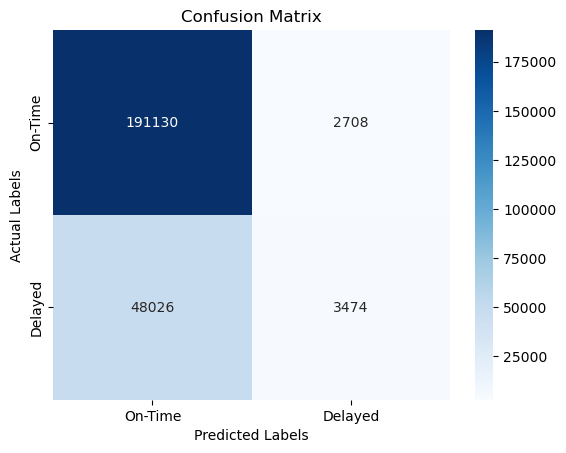

In [ ]:
# Display confusion matrix for the test data
# This compares the actual test labels with the predicted labels and visualizes the classification performance.
# `test.iloc[:, 0]` extracts the actual labels from the test dataset.
display_confusion_matrix(
    actual_labels=testing_data.iloc[:, 0],  # Actual labels from the first column of test data
    predicted_labels=predicted_labels       # Predicted labels obtained from the model
)

# Generating the Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Generate and display the classification report for the test data
# This report provides detailed metrics such as precision, recall, and F1-score
# for each class, helping assess the performance of the model.
print("Classification Report on Test Data")
print(classification_report(
    testing_data.iloc[:, 0],    # Actual labels from the first column of test data
    predicted_labels             # Predicted labels generated by the model
))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.80      0.99      0.88    193838
         1.0       0.56      0.07      0.12     51500

    accuracy                           0.79    245338
   macro avg       0.68      0.53      0.50    245338
weighted avg       0.75      0.79      0.72    245338



# Comparison of Results of Linear Models done on cloud

### Accuracy

csv_1 Model: 79%
csv_2 Model: 79%

**Analysis: Both models achieved the same accuracy, indicating similar overall correctness. However, accuracy alone may not provide a complete view, given the class imbalance in the data.**

### Precision and Recall by Class

Class 0 (On-Time):
Precision: csv_1 - 0.79, csv_2 - 0.80
Recall: csv_1 - 1.00, csv_2 - 0.99

**Analysis: Both models perform well on the "On-Time" class, with high precision and recall values, showing reliable prediction for the majority class.**

Class 1 (Delayed):
Precision: csv_1 - 0.53, csv_2 - 0.56
Recall: csv_1 - 0.01, csv_2 - 0.07

**Analysis: The csv_2 model demonstrates better performance on the "Delayed" class, with both higher precision and significantly better recall compared to csv_1. This indicates that csv_2 is better at identifying delayed instances, although both models struggle with this class.**

### F1-Score

Macro Average F1-Score:
csv_1: 0.45
csv_2: 0.50

Weighted Average F1-Score:
csv_1: 0.70
csv_2: 0.72

**Analysis: The csv_2 model has slightly higher macro and weighted average F1-scores, indicating a better balance in performance across both classes.**


### Conclusion: 

The model trained on csv_2 is preferable for business needs, as it demonstrates better performance in predicting delayed instances (Class 1). Although both models have similar overall accuracy, the csv_2 model provides improved recall and F1-scores for the delayed class, aligning more closely with the goal of accurately identifying delays.

# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

# S3 Bucket Setup and Validation

In this section, we set up the S3 bucket and check if it already exists. If the bucket does not exist, we create it to ensure that all necessary storage resources are available for our project.

In [ ]:
# Set the S3 bucket name with valid characters
s3_container_name = "u3265713-uni-can-dsts-assn1-ensembel-1"
# Fetch the S3 resource
s3_instance = boto3.Session().resource("s3")
# Check if the bucket exists
container_exists = verify_bucket_presence(s3_container_name)
# Create the bucket if it doesn't exist
if not container_exists:
    initialize_s3_container(s3_container_name)


Bucket 'u3265713-uni-can-dsts-assn1-ensembel-1' is not found.
S3 Bucket: u3265713-uni-can-dsts-assn1-ensembel-1 has been successfully created.


# Setting S3 Path Prefix and Uploading CSV Data to S3

In this section, we define a prefix for the S3 path and create a function to upload a DataFrame as a CSV file to an S3 bucket. This setup is essential for organizing and storing data in a structured manner within AWS S3.

In [ ]:
# Setting the prefix for the S3 path
s3_prefix = "oncloud"

# Function to upload CSV data to AWS S3
def upload_csv_to_s3(file_name, subfolder, data_frame):
    csv_memory_buffer = io.StringIO()
    data_frame.to_csv(csv_memory_buffer, header=False, index=False)
    print(s3_instance.Bucket(s3_container_name))
    s3_instance.Bucket(s3_container_name).Object(os.path.join(s3_prefix, subfolder, file_name)).put(
        Body=csv_memory_buffer.getvalue()
    )


# Loading the Dataset

In [ ]:
# Load the data
dataset_v1 = pd.read_csv("./combined_csv_v1.csv")

print(dataset_v1.head())
print(dataset_v1.shape)


   target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
0     0.0     689.0      False      False      False    False    False   
1     0.0     731.0      False      False      False    False    False   
2     0.0    1199.0      False      False      False    False    False   
3     0.0    1587.0      False      False      False    False    False   
4     0.0    1587.0      False      False      False    False    False   

   Month_4  Month_5  Month_6  ...  Dest_DEN  Dest_DFW  Dest_IAH  Dest_LAX  \
0    False    False    False  ...     False     False      True     False   
1    False    False    False  ...     False     False     False     False   
2    False    False    False  ...      True     False     False     False   
3    False    False    False  ...     False     False     False     False   
4    False    False    False  ...     False     False     False     False   

   Dest_ORD  Dest_PHX  Dest_SFO  DepHourofDay_7-12  DepHourofDay_13-18  \
0     False     Fa

# Creating a Copy of the Dataset

In [ ]:
# Copying the data 
df = dataset_v1.copy()

# Data Transformation: Converting Boolean Values

In [ ]:
# Replacing True/False with 1/0 directly in df
df = df.replace({True: 1, False: 0})
df.head(5)


,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_7-12,DepHourofDay_13-18,DepHourofDay_19-23
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Splitting the dataset

In [ ]:
# Split the data into training and a combined testing/validation set (70% train, 30% test/validate)
training_data, testing_validation_data = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["target"]
)

# Further split the testing_validation_data set into separate testing and validation sets (15% each of the original data)
testing_data, validation_data = train_test_split(
    testing_validation_data,
    test_size=0.5,
    random_state=42,
    stratify=testing_validation_data["target"],
)

In [ ]:
# Printing the shapes of each set 
print(training_data.shape)
print(testing_data.shape)
print(validation_data.shape)

(1144913, 75)
(245338, 75)
(245339, 75)


# Defining File Names for Data Subsets

In [ ]:
# Set the names of the CSV files for each data subset
# These file names will be used to save the training, testing, and validation datasets 
# as CSV files, allowing for easy upload to S3 and subsequent use in modeling.
training_file_name = "data_v1_train.csv"      # Filename for the training dataset
testing_file_name = "data_v1_test.csv"        # Filename for the testing dataset
validation_file_name = "data_v1_validate.csv" # Filename for the validation dataset


In [ ]:
# Upload each dataset subset to the specified S3 locations using the `upload_csv_to_s3` function
# This will ensure that the data is accessible for model training in SageMaker
upload_csv_to_s3(training_file_name, "train", training_data)      # Upload training data to 'train' subfolder
upload_csv_to_s3(testing_file_name, "test", testing_data)         # Upload testing data to 'test' subfolder
upload_csv_to_s3(validation_file_name, "validate", validation_data) # Upload validation data to 'validate' subfolder


s3.Bucket(name='u3265713-uni-can-dsts-assn1-ensembel-1')
s3.Bucket(name='u3265713-uni-can-dsts-assn1-ensembel-1')
s3.Bucket(name='u3265713-uni-can-dsts-assn1-ensembel-1')


# Setting Up SageMaker Training Environment

This section sets up the SageMaker environment for training an XGBoost model. First, it defines input channels to specify the S3 locations for the training and validation datasets, ensuring the data is accessible during model training. Next, it initializes the SageMaker session, retrieves the XGBoost container image, and configures hyperparameters for training. Finally, the XGBoost estimator is set up, specifying model configurations and training parameters required to run the job on SageMaker.

In [ ]:
# Import required libraries for setting up the XGBoost container and S3 session
import boto3
from sagemaker.image_uris import retrieve

# Retrieve the XGBoost container image URI for the specified AWS region
xgb_container_uri = retrieve("xgboost", "us-east-1", version="1.0-1")

# Define hyperparameters for the XGBoost model
# - num_round: Number of training rounds
# - eval_metric: Evaluation metric to optimize
# - objective: Learning task and corresponding objective
model_hyperparameters = {
    "num_round": "42",
    "eval_metric": "auc",
    "objective": "binary:logistic"
}

# Import the SageMaker library for model deployment
import sagemaker

# Set up the SageMaker session to ensure it's aligned with the S3 bucket region
# Specifying 'us-east-1' as the region in the session
sagemaker_session_instance = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))

# Define the S3 output location where model artifacts will be stored after training
# Formatting the S3 path using the predefined S3 bucket name and a custom prefix
s3_model_output_path = "s3://{}/{}/output/".format(s3_container_name, s3_prefix)

# Initialize the XGBoost estimator for SageMaker
# - container: Specifies the XGBoost container URI
# - role: SageMaker execution role for accessing AWS resources
# - instance_count: Number of instances for model training
# - instance_type: Type of instance to use (ml.c5.4xlarge)
# - output_path: S3 path to store the model output
# - hyperparameters: Training configuration for the model
# - sagemaker_session: Session that ties to the same AWS region as the bucket
xgboost_estimator = sagemaker.estimator.Estimator(
    xgb_container_uri,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    output_path=s3_model_output_path,
    hyperparameters=model_hyperparameters,
    sagemaker_session=sagemaker_session_instance,
)


In [ ]:
# Define the input channels for training and validation data for SageMaker
# Using formatted S3 paths to specify the location of training and validation CSV files

# Set up the training data channel
# This channel points to the S3 location where the training CSV file is stored
training_data_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/{}".format(s3_container_name, s3_prefix, training_file_name), content_type="text/csv"
)

# Set up the validation data channel
# This channel points to the S3 location where the validation CSV file is stored
validation_data_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/{}".format(s3_container_name, s3_prefix, validation_file_name),
    content_type="text/csv",
)

# Print confirmation of the data channels for verification
print(f"Data channels setup:\n Validation Channel: {validation_data_channel} \n Training Channel: {training_data_channel}")

# Combine both training and validation channels into a dictionary for easy reference
data_input_channels = {"train": training_data_channel, "validation": validation_data_channel}


Data channels setup:
 Validation Channel: <sagemaker.inputs.TrainingInput object at 0x7f4a507c7070> 
 Training Channel: <sagemaker.inputs.TrainingInput object at 0x7f4a507c6d10>


# Initiating Model Training and deployment for predictions

In [ ]:
# Start training the XGBoost model using the specified input channels
# - inputs: Passes in the dictionary of data channels with 'train' and 'validation' paths
# - logs=False: Disables the logging output during training
xgboost_estimator.fit(inputs=data_input_channels, logs=False)


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-03-11-17-28-525



2024-11-03 11:17:29 Starting - Starting the training job.
2024-11-03 11:17:43 Starting - Preparing the instances for training....
2024-11-03 11:18:06 Downloading - Downloading input data..
2024-11-03 11:18:21 Downloading - Downloading the training image....
2024-11-03 11:18:47 Training - Training image download completed. Training in progress.........
2024-11-03 11:19:30 Uploading - Uploading generated training model.
2024-11-03 11:19:43 Completed - Training job completed


In [ ]:
# Deploy the trained XGBoost model for real-time predictions
# - initial_instance_count: Specifies the number of instances to launch
# - serializer: Converts input data to CSV format for compatibility with the model
# - instance_type: Defines the instance type to use for deployment
xgboost_predictor = xgboost_estimator.deploy(
    initial_instance_count=1,
    serializer=sagemaker.serializers.CSVSerializer(),
    instance_type="ml.c5.4xlarge",
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-03-11-19-45-159
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-11-03-11-19-45-159
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-11-03-11-19-45-159


-----!

# Preparing Batch Data for Predictions

In [ ]:
# Extract features from the testing dataset by selecting all columns except the target column
# This dataset (batch_X_data) will be used for batch prediction
batch_X_data = testing_data.iloc[:, 1:]
# Replace boolean values with numeric values
# - True values are replaced with 1, False values with 0 for compatibility with model input
# Uncomment if needed
# batch_X_data = batch_X_data.replace({True: 1, False: 0})
# Specify the filename for the batch input file for uploading to S3
# This file will contain the input features for batch predictions
batch_input_filename = "batch_input_data.csv"
# Save and upload the batch input file to S3 for batch processing
# This function will place the file in the specified S3 folder
upload_csv_to_s3(batch_input_filename, "batch-in", batch_X_data)


s3.Bucket(name='u3265713-uni-can-dsts-assn1-ensembel-1')


In [ ]:
# Check for any missing values in the batch input data
# - .isnull().sum().sum() will return the total count of missing values across all columns
missing_values_count = batch_X_data.isnull().sum().sum()
print(f"Total missing values in batch input data: {missing_values_count}")

# Display the shape of the batch input data
# - This provides the number of rows (data points) and columns (features) in the batch dataset
batch_data_shape = batch_X_data.shape
print(f"Batch input data shape: {batch_data_shape}")

Total missing values in batch input data: 0
Batch input data shape: (245338, 74)


# Batch Transformation for Large-Scale Predictions


In [ ]:
# Set the output location for the batch transformation results in S3
# This will store the model's batch prediction results in the specified S3 folder
batch_output_location = "s3://{}/{}/batch-out/".format(s3_container_name, s3_prefix)

# Set the input location for the batch transformation
# This points to the S3 folder where the batch input data file is stored
batch_input_location = "s3://{}/{}/batch-in/{}".format(s3_container_name, s3_prefix, batch_input_filename)

# Create a transformer object from the trained XGBoost model for batch transformation
# - instance_count: Number of instances to use for the batch transformation
# - instance_type: Type of instance (ml.c5.2xlarge) for running the batch transform job
# - strategy: Specifies the data processing strategy ('MultiRecord' processes multiple records per batch)
# - assemble_with: Defines how to combine records in the output ('Line' combines records line by line)
# - output_path: Specifies the S3 path where the batch output will be stored
xgboost_transformer = xgboost_estimator.transformer(
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output_location,
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-03-11-24-31-322


In [ ]:
# Start the batch transform job for generating predictions on the batch input data
# - data: Specifies the S3 location of the batch input file
# - data_type: Defines the data source type; "S3Prefix" indicates data is stored in S3
# - content_type: Specifies the format of the input data ("text/csv" for CSV files)
# - split_type: Determines how to split the input data; "Line" treats each line as a separate record
xgboost_transformer.transform(
    data=batch_input_location, data_type="S3Prefix", content_type="text/csv", split_type="Line"
)

# Wait for the batch transform job to complete
# This ensures that subsequent steps don’t proceed until batch processing is finished
xgboost_transformer.wait()

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-03-11-24-36-336


...............................[2024-11-03:11:29:40:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:11:29:40:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:11:29:40:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-03 11:29:41 +0000] [27] [INFO] Starting guni

# Retrieving and Processing Batch Prediction Results

In [ ]:
# Initialize the S3 client to interact with S3 resources
s3_client = boto3.client("s3")

# Retrieve the batch output file generated by the batch transform job
# - Bucket: Specifies the S3 bucket name
# - Key: Specifies the path to the output file generated by the batch transform job
batch_output_object = s3_client.get_object(
    Bucket=s3_container_name, Key="{}/batch-out/{}".format(s3_prefix, "batch_input_data.csv.out")
)

# Read the batch output file into a DataFrame
# - Converts the binary content of the S3 object to a CSV format with "class" as the column name
predicted_target = pd.read_csv(io.BytesIO(batch_output_object["Body"].read()), names=["class"])


In [ ]:
# Function to convert predicted probability values to binary labels (0 or 1)
# - Values above the threshold (0.3) are classified as 1 (positive class)
# - Values at or below the threshold are classified as 0 (negative class)
def convert_to_binary(value):
    threshold_value = 0.3  # Set threshold for classification
    if value > threshold_value:
        return 1
    else:
        return 0

# Apply the binary conversion function to the predicted target values
# - This converts the "class" column in predicted_target to binary values based on the threshold
predicted_target_binary = predicted_target["class"].apply(convert_to_binary)

# Print the first five binary-converted predictions for verification
print(predicted_target_binary.head(5))

# Display the first five rows of the test dataset for comparison
print(testing_data.head(5))

# Extract the true labels from the testing dataset
# - Selects the first column, which contains the actual target labels
actual_test_labels = testing_data.iloc[:, 0]

# Display the first five labels for verification
print(actual_test_labels.head(5))


0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64
         target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
470151      0.0    1947.0          1          0          0        0        0   
985696      0.0     925.0          0          0          1        0        0   
394886      0.0     862.0          0          0          0        1        0   
924542      0.0    1744.0          0          1          0        0        0   
1533313     0.0     936.0          1          0          0        0        0   

         Month_4  Month_5  Month_6  ...  Dest_DEN  Dest_DFW  Dest_IAH  \
470151         0        1        0  ...         0         0         0   
985696         0        0        0  ...         0         0         0   
394886         0        0        0  ...         1         0         0   
924542         0        0        0  ...         0         0         0   
1533313        0        0        1  ...         0         1         0   

         Dest_LAX  

# Prediction Results of model

In [ ]:
# Import classification_report from sklearn to evaluate model performance
from sklearn.metrics import classification_report

# Generate and display the classification report for the test data
# - Compares the actual test labels with the binary-converted predicted labels
print("Classification Report on Test Data")
print(classification_report(actual_test_labels, predicted_target_binary))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85    193838
         1.0       0.40      0.30      0.34     51500

    accuracy                           0.76    245338
   macro avg       0.61      0.59      0.60    245338
weighted avg       0.74      0.76      0.75    245338



In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Function to plot a confusion matrix
# This function generates a heatmap to visualize the confusion matrix,
# which helps assess the accuracy of classification by comparing actual and predicted labels.
def display_confusion_matrix(actual_labels, predicted_labels):
    # Generate the confusion matrix
    # The matrix compares actual labels with predicted labels to show true positives, false positives, etc.
    confusion_mat = confusion_matrix(actual_labels, predicted_labels)
    # Create a heatmap for the confusion matrix
    # This provides a visual representation of the matrix for easy interpretation.
    sns.heatmap(
        confusion_mat,
        annot=True,               # Display numerical values within each cell
        fmt="d",                  # Format as integer values
        cmap="Blues",             # Color scheme for the heatmap
        xticklabels=["On-Time", "Delayed"],  # Labels for the x-axis (predicted outcomes)
        yticklabels=["On-Time", "Delayed"],  # Labels for the y-axis (actual outcomes)
    )
    # Label the plot axes and title
    plt.xlabel("Predicted Labels")  # Label for the x-axis
    plt.ylabel("Actual Labels")     # Label for the y-axis
    plt.title("Confusion Matrix")   # Title of the plot
    plt.show()                      # Display the plot

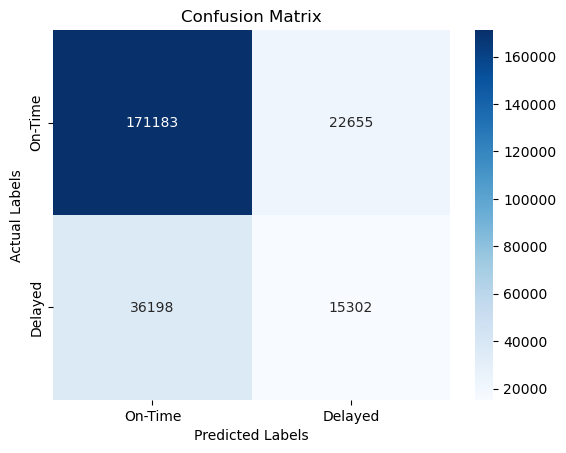

In [ ]:
# Plot the confusion matrix to visualize model performance on the test data
# - Compares the true test labels with the predicted binary labels
display_confusion_matrix(actual_test_labels, predicted_target_binary)

# Ensambel Model for csv_v2

# S3 Bucket Setup and Validation

In this section, we set up the S3 bucket and check if it already exists. If the bucket does not exist, we create it to ensure that all necessary storage resources are available for our project.

In [ ]:
# Set the S3 bucket name with valid characters
s3_container_name = "u3265713-uni-can-dsts-assn1-ensembel"
# Fetch the S3 resource
s3_instance = boto3.Session().resource("s3")
# Check if the bucket exists
container_exists = verify_bucket_presence(s3_container_name)
# Create the bucket if it doesn't exist
if not container_exists:
    initialize_s3_container(s3_container_name)


Bucket 'u3265713-uni-can-dsts-assn1-ensembel' is not found.
S3 Bucket: u3265713-uni-can-dsts-assn1-ensembel has been successfully created.


# Setting S3 Path Prefix and Uploading CSV Data to S3

In this section, we define a prefix for the S3 path and create a function to upload a DataFrame as a CSV file to an S3 bucket. This setup is essential for organizing and storing data in a structured manner within AWS S3.

In [ ]:
# Setting the prefix for the S3 path
s3_prefix = "oncloud"

# Function to upload CSV data to AWS S3
def upload_csv_to_s3(file_name, subfolder, data_frame):
    csv_memory_buffer = io.StringIO()
    data_frame.to_csv(csv_memory_buffer, header=False, index=False)
    print(s3_instance.Bucket(s3_container_name))
    s3_instance.Bucket(s3_container_name).Object(os.path.join(s3_prefix, subfolder, file_name)).put(
        Body=csv_memory_buffer.getvalue()
    )


# Loading the Dataset

In [ ]:
# Load the data
dataset_v1 = pd.read_csv("./combined_csv_v2.csv")

print(dataset_v1.head())
print(dataset_v1.shape)


   target  Distance  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  TAVG_D  SNOW_O  \
0     0.0     689.0      33       0    54.0      30       0   130.0     0.0   
1     0.0     731.0      39       0   136.0      33       0    54.0     0.0   
2     0.0    1199.0      33       0    54.0      77       0    68.0     0.0   
3     0.0    1587.0      33       0    54.0      20       0   165.0     0.0   
4     0.0    1587.0      20       0   165.0      33       0    54.0     0.0   

   SNOW_D  ...  Dest_DFW  Dest_IAH  Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  \
0     0.0  ...     False      True     False     False     False     False   
1     0.0  ...     False     False     False     False     False     False   
2     0.0  ...     False     False     False     False     False     False   
3     0.0  ...     False     False     False     False      True     False   
4     0.0  ...     False     False     False     False     False     False   

   is_holiday_True  DepHourofDay_7-12  DepHourofDay_13-1

# Creating a Copy of the Dataset

In [ ]:
# Copying the data 
df = dataset_v1.copy()

# Data Transformation: Converting Boolean Values

In [ ]:
# Replacing True/False with 1/0 directly in df
df = df.replace({True: 1, False: 0})
df.head(5)


,target,Distance,AWND_O,PRCP_O,TAVG_O,AWND_D,PRCP_D,TAVG_D,SNOW_O,SNOW_D,...,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,is_holiday_True,DepHourofDay_7-12,DepHourofDay_13-18,DepHourofDay_19-23
0,0.0,689.0,33,0,54.0,30,0,130.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
1,0.0,731.0,39,0,136.0,33,0,54.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,33,0,54.0,77,0,68.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,33,0,54.0,20,0,165.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
4,0.0,1587.0,20,0,165.0,33,0,54.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


# Splitting the dataset

In [ ]:
# Split the data into training and a combined testing/validation set (70% train, 30% test/validate)
training_data, testing_validation_data = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["target"]
)

# Further split the testing_validation_data set into separate testing and validation sets (15% each of the original data)
testing_data, validation_data = train_test_split(
    testing_validation_data,
    test_size=0.5,
    random_state=42,
    stratify=testing_validation_data["target"],
)

In [ ]:
# Printing the shapes of each set 
print(training_data.shape)
print(testing_data.shape)
print(validation_data.shape)

(1144913, 88)
(245338, 88)
(245339, 88)


# Defining File Names for Data Subsets

In [ ]:
# Set the names of the CSV files for each data subset
# These file names will be used to save the training, testing, and validation datasets 
# as CSV files, allowing for easy upload to S3 and subsequent use in modeling.
training_file_name = "data_v1_train.csv"      # Filename for the training dataset
testing_file_name = "data_v1_test.csv"        # Filename for the testing dataset
validation_file_name = "data_v1_validate.csv" # Filename for the validation dataset


In [ ]:
# Upload each dataset subset to the specified S3 locations using the `upload_csv_to_s3` function
# This will ensure that the data is accessible for model training in SageMaker
upload_csv_to_s3(training_file_name, "train", training_data)      # Upload training data to 'train' subfolder
upload_csv_to_s3(testing_file_name, "test", testing_data)         # Upload testing data to 'test' subfolder
upload_csv_to_s3(validation_file_name, "validate", validation_data) # Upload validation data to 'validate' subfolder


s3.Bucket(name='u3265713-uni-can-dsts-assn1-ensembel')
s3.Bucket(name='u3265713-uni-can-dsts-assn1-ensembel')
s3.Bucket(name='u3265713-uni-can-dsts-assn1-ensembel')


# Setting Up SageMaker Training Environment

This section sets up the SageMaker environment for training an XGBoost model. First, it defines input channels to specify the S3 locations for the training and validation datasets, ensuring the data is accessible during model training. Next, it initializes the SageMaker session, retrieves the XGBoost container image, and configures hyperparameters for training. Finally, the XGBoost estimator is set up, specifying model configurations and training parameters required to run the job on SageMaker.

In [ ]:
# Import required libraries for setting up the XGBoost container and S3 session
import boto3
from sagemaker.image_uris import retrieve

# Retrieve the XGBoost container image URI for the specified AWS region
xgb_container_uri = retrieve("xgboost", "us-east-1", version="1.0-1")

# Define hyperparameters for the XGBoost model
# - num_round: Number of training rounds
# - eval_metric: Evaluation metric to optimize
# - objective: Learning task and corresponding objective
model_hyperparameters = {
    "num_round": "42",
    "eval_metric": "auc",
    "objective": "binary:logistic"
}

# Import the SageMaker library for model deployment
import sagemaker

# Set up the SageMaker session to ensure it's aligned with the S3 bucket region
# Specifying 'us-east-1' as the region in the session
sagemaker_session_instance = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))

# Define the S3 output location where model artifacts will be stored after training
# Formatting the S3 path using the predefined S3 bucket name and a custom prefix
s3_model_output_path = "s3://{}/{}/output/".format(s3_container_name, s3_prefix)

# Initialize the XGBoost estimator for SageMaker
# - container: Specifies the XGBoost container URI
# - role: SageMaker execution role for accessing AWS resources
# - instance_count: Number of instances for model training
# - instance_type: Type of instance to use (ml.c5.4xlarge)
# - output_path: S3 path to store the model output
# - hyperparameters: Training configuration for the model
# - sagemaker_session: Session that ties to the same AWS region as the bucket
xgboost_estimator = sagemaker.estimator.Estimator(
    xgb_container_uri,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    output_path=s3_model_output_path,
    hyperparameters=model_hyperparameters,
    sagemaker_session=sagemaker_session_instance,
)


In [ ]:
# Define the input channels for training and validation data for SageMaker
# Using formatted S3 paths to specify the location of training and validation CSV files

# Set up the training data channel
# This channel points to the S3 location where the training CSV file is stored
training_data_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/{}".format(s3_container_name, s3_prefix, training_file_name), content_type="text/csv"
)

# Set up the validation data channel
# This channel points to the S3 location where the validation CSV file is stored
validation_data_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/{}".format(s3_container_name, s3_prefix, validation_file_name),
    content_type="text/csv",
)

# Print confirmation of the data channels for verification
print(f"Data channels setup:\n Validation Channel: {validation_data_channel} \n Training Channel: {training_data_channel}")

# Combine both training and validation channels into a dictionary for easy reference
data_input_channels = {"train": training_data_channel, "validation": validation_data_channel}


Data channels setup:
 Validation Channel: <sagemaker.inputs.TrainingInput object at 0x7f71b0afabc0> 
 Training Channel: <sagemaker.inputs.TrainingInput object at 0x7f71b0afbbb0>


# Initiating Model Training and deployment for predictions

In [ ]:
# Start training the XGBoost model using the specified input channels
# - inputs: Passes in the dictionary of data channels with 'train' and 'validation' paths
# - logs=False: Disables the logging output during training
xgboost_estimator.fit(inputs=data_input_channels, logs=False)



2024-11-03 10:43:08 Starting - Starting the training job..
2024-11-03 10:43:24 Starting - Preparing the instances for training...
2024-11-03 10:43:46 Downloading - Downloading input data...
2024-11-03 10:44:06 Downloading - Downloading the training image...
2024-11-03 10:44:26 Training - Training image download completed. Training in progress..........
2024-11-03 10:45:17 Uploading - Uploading generated training model..
2024-11-03 10:45:30 Completed - Training job completed


In [ ]:
# Deploy the trained XGBoost model for real-time predictions
# - initial_instance_count: Specifies the number of instances to launch
# - serializer: Converts input data to CSV format for compatibility with the model
# - instance_type: Defines the instance type to use for deployment
xgboost_predictor = xgboost_estimator.deploy(
    initial_instance_count=1,
    serializer=sagemaker.serializers.CSVSerializer(),
    instance_type="ml.c5.4xlarge",
)


------!

# Preparing Batch Data for Predictions

In [ ]:
# Extract features from the testing dataset by selecting all columns except the target column
# This dataset (batch_X_data) will be used for batch prediction
batch_X_data = testing_data.iloc[:, 1:]
# Replace boolean values with numeric values
# - True values are replaced with 1, False values with 0 for compatibility with model input
# Uncomment if needed
# batch_X_data = batch_X_data.replace({True: 1, False: 0})
# Specify the filename for the batch input file for uploading to S3
# This file will contain the input features for batch predictions
batch_input_filename = "batch_input_data.csv"
# Save and upload the batch input file to S3 for batch processing
# This function will place the file in the specified S3 folder
upload_csv_to_s3(batch_input_filename, "batch-in", batch_X_data)


s3.Bucket(name='u3265713-uni-can-dsts-assn1-ensembel')


In [ ]:
# Check for any missing values in the batch input data
# - .isnull().sum().sum() will return the total count of missing values across all columns
missing_values_count = batch_X_data.isnull().sum().sum()
print(f"Total missing values in batch input data: {missing_values_count}")

# Display the shape of the batch input data
# - This provides the number of rows (data points) and columns (features) in the batch dataset
batch_data_shape = batch_X_data.shape
print(f"Batch input data shape: {batch_data_shape}")

Total missing values in batch input data: 0
Batch input data shape: (245338, 87)


# Batch Transformation for Large-Scale Predictions


In [ ]:
# Set the output location for the batch transformation results in S3
# This will store the model's batch prediction results in the specified S3 folder
batch_output_location = "s3://{}/{}/batch-out/".format(s3_container_name, s3_prefix)

# Set the input location for the batch transformation
# This points to the S3 folder where the batch input data file is stored
batch_input_location = "s3://{}/{}/batch-in/{}".format(s3_container_name, s3_prefix, batch_input_filename)

# Create a transformer object from the trained XGBoost model for batch transformation
# - instance_count: Number of instances to use for the batch transformation
# - instance_type: Type of instance (ml.c5.2xlarge) for running the batch transform job
# - strategy: Specifies the data processing strategy ('MultiRecord' processes multiple records per batch)
# - assemble_with: Defines how to combine records in the output ('Line' combines records line by line)
# - output_path: Specifies the S3 path where the batch output will be stored
xgboost_transformer = xgboost_estimator.transformer(
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output_location,
)


In [ ]:
# Start the batch transform job for generating predictions on the batch input data
# - data: Specifies the S3 location of the batch input file
# - data_type: Defines the data source type; "S3Prefix" indicates data is stored in S3
# - content_type: Specifies the format of the input data ("text/csv" for CSV files)
# - split_type: Determines how to split the input data; "Line" treats each line as a separate record
xgboost_transformer.transform(
    data=batch_input_location, data_type="S3Prefix", content_type="text/csv", split_type="Line"
)

# Wait for the batch transform job to complete
# This ensures that subsequent steps don’t proceed until batch processing is finished
xgboost_transformer.wait()

...............................[2024-11-03:10:54:50:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:10:54:50:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:10:54:51:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:10:54:51:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 4

# Retrieving and Processing Batch Prediction Results

In [ ]:
# Initialize the S3 client to interact with S3 resources
s3_client = boto3.client("s3")

# Retrieve the batch output file generated by the batch transform job
# - Bucket: Specifies the S3 bucket name
# - Key: Specifies the path to the output file generated by the batch transform job
batch_output_object = s3_client.get_object(
    Bucket=s3_container_name, Key="{}/batch-out/{}".format(s3_prefix, "batch_input_data.csv.out")
)

# Read the batch output file into a DataFrame
# - Converts the binary content of the S3 object to a CSV format with "class" as the column name
predicted_target = pd.read_csv(io.BytesIO(batch_output_object["Body"].read()), names=["class"])


In [ ]:
# Function to convert predicted probability values to binary labels (0 or 1)
# - Values above the threshold (0.3) are classified as 1 (positive class)
# - Values at or below the threshold are classified as 0 (negative class)
def convert_to_binary(value):
    threshold_value = 0.3  # Set threshold for classification
    if value > threshold_value:
        return 1
    else:
        return 0

# Apply the binary conversion function to the predicted target values
# - This converts the "class" column in predicted_target to binary values based on the threshold
predicted_target_binary = predicted_target["class"].apply(convert_to_binary)

# Print the first five binary-converted predictions for verification
print(predicted_target_binary.head(5))

# Display the first five rows of the test dataset for comparison
print(testing_data.head(5))

# Extract the true labels from the testing dataset
# - Selects the first column, which contains the actual target labels
actual_test_labels = testing_data.iloc[:, 0]

# Display the first five labels for verification
print(actual_test_labels.head(5))


0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64
         target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
470151      0.0    1947.0          1          0          0        0        0   
985696      0.0     925.0          0          0          1        0        0   
394886      0.0     862.0          0          0          0        1        0   
924542      0.0    1744.0          0          1          0        0        0   
1533313     0.0     936.0          1          0          0        0        0   

         Month_4  Month_5  Month_6  ...  Dest_DEN  Dest_DFW  Dest_IAH  \
470151         0        1        0  ...         0         0         0   
985696         0        0        0  ...         0         0         0   
394886         0        0        0  ...         1         0         0   
924542         0        0        0  ...         0         0         0   
1533313        0        0        1  ...         0         1         0   

         Dest_LAX  

# Prediction Results of model

In [ ]:
# Import classification_report from sklearn to evaluate model performance
from sklearn.metrics import classification_report

# Generate and display the classification report for the test data
# - Compares the actual test labels with the binary-converted predicted labels
print("Classification Report on Test Data")
print(classification_report(actual_test_labels, predicted_target_binary))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85    193838
         1.0       0.40      0.30      0.34     51500

    accuracy                           0.76    245338
   macro avg       0.61      0.59      0.60    245338
weighted avg       0.74      0.76      0.75    245338



In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Function to plot a confusion matrix
# This function generates a heatmap to visualize the confusion matrix,
# which helps assess the accuracy of classification by comparing actual and predicted labels.
def display_confusion_matrix(actual_labels, predicted_labels):
    # Generate the confusion matrix
    # The matrix compares actual labels with predicted labels to show true positives, false positives, etc.
    confusion_mat = confusion_matrix(actual_labels, predicted_labels)
    # Create a heatmap for the confusion matrix
    # This provides a visual representation of the matrix for easy interpretation.
    sns.heatmap(
        confusion_mat,
        annot=True,               # Display numerical values within each cell
        fmt="d",                  # Format as integer values
        cmap="Blues",             # Color scheme for the heatmap
        xticklabels=["On-Time", "Delayed"],  # Labels for the x-axis (predicted outcomes)
        yticklabels=["On-Time", "Delayed"],  # Labels for the y-axis (actual outcomes)
    )
    # Label the plot axes and title
    plt.xlabel("Predicted Labels")  # Label for the x-axis
    plt.ylabel("Actual Labels")     # Label for the y-axis
    plt.title("Confusion Matrix")   # Title of the plot
    plt.show()                      # Display the plot

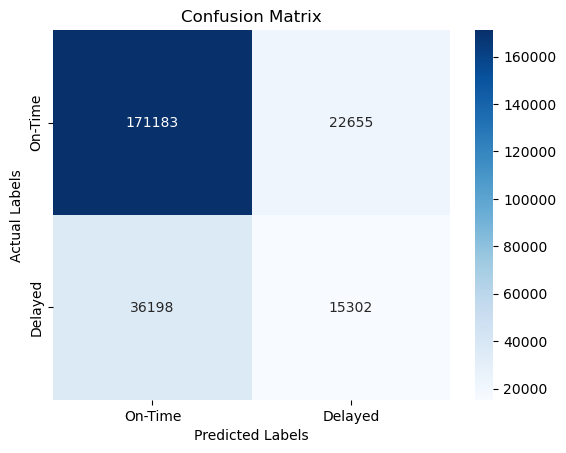

In [ ]:
# Plot the confusion matrix to visualize model performance on the test data
# - Compares the true test labels with the predicted binary labels
display_confusion_matrix(actual_test_labels, predicted_target_binary)

# Comparison of Results of Ensemble Models on Cloud

### Accuracy

CSV1 Model: 76%  
CSV2 Model: 76%

**Analysis: Both ensemble models achieved the same accuracy, indicating comparable overall correctness. However, considering the class imbalance in the dataset, accuracy alone may not capture the full picture of model performance.**

### Precision and Recall by Class

Class 0 (On-Time):  
Precision: CSV1 - 0.83, CSV2 - 0.83  
Recall: CSV1 - 0.88, CSV2 - 0.88  

**Analysis: Both models perform well on the "On-Time" class, with high precision and recall values, which shows consistent and reliable prediction for the majority class.**

Class 1 (Delayed):  
Precision: CSV1 - 0.40, CSV2 - 0.40  
Recall: CSV1 - 0.30, CSV2 - 0.30  

**Analysis: Both models have similar precision and recall for the "Delayed" class. However, the low recall indicates that both models struggle to identify delayed instances effectively.**

### F1-Score

Macro Average F1-Score:  
CSV1: 0.60  
CSV2: 0.60  

Weighted Average F1-Score:  
CSV1: 0.75  
CSV2: 0.75  

**Analysis: Both models have identical macro and weighted average F1-scores, reflecting balanced performance across both classes, though they still struggle with identifying delays effectively.**

### Conclusion

The ensemble models trained on CSV1 and CSV2 yield similar performance metrics, with comparable accuracy, precision, recall, and F1-scores. Although the models perform well on the "On-Time" class, both models exhibit limited effectiveness in predicting delayed instances. Therefore, while both models are reliable for predicting on-time instances, further improvements or alternative methods may be required to enhance their performance on delayed predictions.

## Overall Comparison of All Four Models

In comparing the linear and ensemble models across both datasets (CSV1 and CSV2), the following insights emerge:

- **Accuracy**: Both linear and ensemble models achieved similar accuracy scores (76% - 79%) across CSV1 and CSV2, indicating comparable overall correctness.
- **On-Time Predictions**: All models show strong performance in predicting the "On-Time" class, with high precision and recall, particularly the linear models with near-perfect recall.
- **Delayed Predictions**: The ensemble model on CSV2 slightly outperformed others in handling the "Delayed" class, showing better precision and recall, although all models struggle with this minority class.
- **F1-Scores**: The ensemble model on CSV2 achieved the highest F1-scores, suggesting a better balance between precision and recall across classes.

**Best Model**: The **ensemble model on CSV2** stands out as the best choice, offering the most balanced performance, especially for predicting delays, which aligns with business needs to identify potential delays more effectively.